# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))/100).to_dict()
inventory_weights.pop('Total')
inventory_weights

{'BTCUSDT': 0.3839,
 'JASMYUSDT': 0.18960000000000002,
 'ETHUSDT': 0.1392,
 'SOLUSDT': 0.1151,
 'MKRUSDT': 0.0587,
 'BBUSDT': 0.0564,
 'PEPEUSDT': 0.0348,
 'BNBUSDT': 0.0223,
 'FETUSDT': 0.0,
 'TRXUSDT': 0.0}

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))

### Positions

In [11]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1))
positions=positions.sort_index()
positions.index=pd.to_datetime(positions.index)
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

2024-05-05 00:00:00
2024-06-04 00:00:00
LDUMAUSDT not retrieved


In [12]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,5))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=np.log(1+binance_data.pct_change())

LDUMAUSDT not retrieved
Total not retrieved


In [13]:
historical_ptf=pd.DataFrame()

In [14]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

In [15]:
historical_ptf['Historical Portfolio']

2024-05-04    0.000000
2024-05-05    0.000000
2024-05-06    0.000000
2024-05-07    0.000000
2024-05-08    0.000000
2024-05-09    0.060757
2024-05-10    0.000000
2024-05-11    0.012773
2024-05-12    0.000000
2024-05-13    0.000000
2024-05-14   -0.043904
2024-05-15    0.076429
2024-05-16   -0.013172
2024-05-17    0.037886
2024-05-18    0.000000
2024-05-19    0.000000
2024-05-20    0.098363
2024-05-21   -0.014657
2024-05-22   -0.014925
2024-05-23   -0.019633
2024-05-24   -0.018022
2024-05-25    0.049991
2024-05-26    0.040639
2024-05-27    0.006906
2024-05-28   -0.014313
2024-05-29   -0.023178
2024-05-30    0.021355
2024-05-31    0.007437
2024-06-01    0.026174
2024-06-02   -0.018180
2024-06-03    0.001344
2024-06-04    0.030375
2024-06-05    0.031075
2024-06-06   -0.015019
2024-06-07   -0.041131
2024-06-08   -0.022456
2024-06-09    0.017172
2024-06-10   -0.020273
2024-06-11   -0.050882
2024-06-12    0.031308
2024-06-13   -0.048318
2024-06-14   -0.008656
2024-06-15    0.020028
2024-06-16 

<AxesSubplot:>

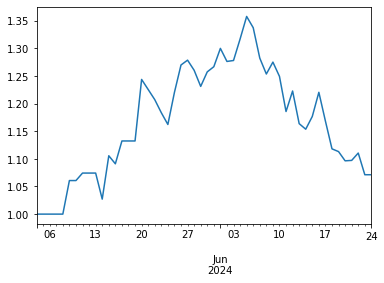

In [16]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [17]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [18]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [19]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'AGIXUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GNOUSDT',
       'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT',
       'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT',
       'NEOUSDT', 'OPUSDT', 'ORDIUSDT', 'PENDLEUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RNDRUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

## Optimal Portfolio

In [20]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[21]-0.15},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[13]-0.3}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
BTCUSDT,0.300000
BNBUSDT,0.196215
ETHUSDT,0.150000
JASMYUSDT,0.137577
PENDLEUSDT,0.124245
PEPEUSDT,0.091962


In [21]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.3},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[2]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
JASMYUSDT,0.55
BTCUSDT,0.30
ETHUSDT,0.15


## Real Portfolio vs Optimal

In [22]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current*100],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,641.137898,38.392292,30.0,8.392292
JASMYUSDT,316.608932,18.959014,55.0,-36.040986
ETHUSDT,232.428619,13.918172,15.0,-1.081828
SOLUSDT,192.211288,11.509898,0.0,0.000000
MKRUSDT,98.072499,5.872727,0.0,0.000000
BBUSDT,94.153104,5.638028,0.0,0.000000
PEPEUSDT,58.033631,3.475140,0.0,0.000000
BNBUSDT,37.282638,2.232540,0.0,0.000000
FETUSDT,0.019410,0.001162,0.0,0.000000
TRXUSDT,0.017152,0.001027,0.0,0.000000


In [23]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory*100],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,641.137898,38.392292,30.0000,8.392292
JASMYUSDT,316.608932,18.959014,13.7577,5.201314
ETHUSDT,232.428619,13.918172,15.0000,-1.081828
SOLUSDT,192.211288,11.509898,0.0000,0.000000
MKRUSDT,98.072499,5.872727,0.0000,0.000000
BBUSDT,94.153104,5.638028,0.0000,0.000000
PEPEUSDT,58.033631,3.475140,9.1962,-5.721060
BNBUSDT,37.282638,2.232540,19.6215,-17.388960
FETUSDT,0.019410,0.001162,0.0000,0.000000
TRXUSDT,0.017152,0.001027,0.0000,0.000000


## Risk Reward Analysis

<AxesSubplot:>

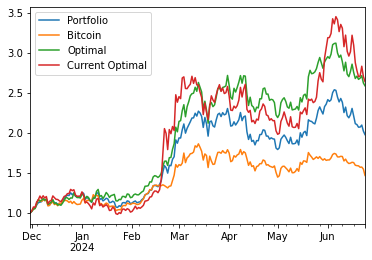

In [24]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
(1+portfolio_perf).cumprod().plot()

In [25]:
portfolio_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

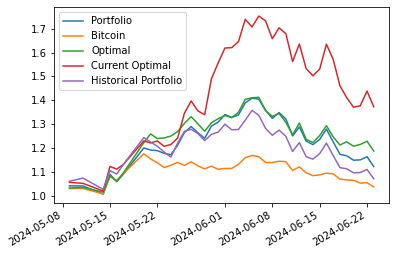

In [26]:
(1+portfolio_perf.loc[positions.index]).cumprod().plot()

In [27]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.531743
dtype: float64

In [28]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio               0.507941
Bitcoin                 0.444563
Optimal                 0.533002
Current Optimal         0.745088
Historical Portfolio    0.489278
dtype: float64

In [29]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.164542,0.177319,0.180985,0.066052,0.114933
BTCUSDT,0.095051,0.177726,0.356520,0.154406,0.202114
ETHUSDT,0.047880,0.089075,0.172587,0.038601,0.133985
JASMYUSDT,0.238746,0.197935,0.104833,0.032472,0.072360
PENDLEUSDT,0.213814,0.177682,0.101515,0.026484,0.075032
PEPEUSDT,0.239967,0.180263,0.083560,0.014509,0.069051


In [30]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.732807,0.352381,0.440514,0.224918,0.215596
JASMYUSDT,2.904830,0.266238,0.161795,0.054861,0.106934
ETHUSDT,0.526123,0.150121,0.146238,0.029571,0.116667
SOLUSDT,-0.540674,0.096591,0.121315,0.020218,0.101097
MKRUSDT,-0.429044,0.044933,0.053982,0.005259,0.048724
BBUSDT,-0.718262,0.034535,0.038687,0.004855,0.033833
PEPEUSDT,0.034638,0.034795,0.019131,0.001848,0.017283
BNBUSDT,-0.044805,0.020406,0.018337,0.000759,0.017578


## Value At Risk

### Historical

In [31]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05004058504351248, -0.06611988685204889)

In [32]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04246169118178484, -0.04744191090852542)

### Parametric

In [33]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.05522756676224422, -0.07078647101266633)

In [34]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05427206779363926, -0.06956178551574839)

### Multivariate

In [35]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05022873365734018, -0.06438392919543952)

In [36]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05332046582717692, -0.06716361813656103)

### Copulas

In [37]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.04863952057437372, -0.06358120129136834)

In [38]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05210398372376412, -0.06558262094943049)

In [39]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05022123815478517, -0.06446703807626854)

In [40]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0532117624847898, -0.06728265103749431)

### Monte Carlo

In [41]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.055519420615992854, -0.0694265516996056)

In [42]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0555651266215145, -0.06929109187425875)

### VaR Violation

In [43]:
var_data=rolling_var(returns_to_use,opt_weights,window=15,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.029669,-0.053526,-0.049790,0.000214
2023-12-31,-0.029669,-0.053765,-0.050365,-0.004251
2024-01-01,-0.028901,-0.054945,-0.046433,0.039318
2024-01-02,-0.028901,-0.056155,-0.048666,-0.011455
2024-01-03,-0.033992,-0.061023,-0.055572,-0.034491
...,...,...,...,...
2024-06-20,-0.050187,-0.065894,-0.078030,-0.014915
2024-06-21,-0.050187,-0.066254,-0.074080,0.006010
2024-06-22,-0.050187,-0.064426,-0.071377,0.011181
2024-06-23,-0.050187,-0.066155,-0.073202,-0.033509


In [44]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=5,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-18,-0.032599,-0.109545,-0.094856,0.008210
2024-05-19,-0.027750,-0.106284,-0.093300,-0.026646
2024-05-20,-0.027750,-0.122421,-0.107378,0.100230
2024-05-21,-0.025870,-0.113872,-0.094953,-0.007235
2024-05-22,-0.025870,-0.115372,-0.100051,-0.002338
2024-05-23,-0.025957,-0.118085,-0.110155,-0.009415
2024-05-24,-0.009328,-0.110652,-0.094913,-0.004871
2024-05-25,-0.009328,-0.041988,-0.039511,0.033960
2024-05-26,-0.009233,-0.057298,-0.045903,0.043555
2024-05-27,-0.009233,-0.054280,-0.038396,0.020054


<AxesSubplot:>

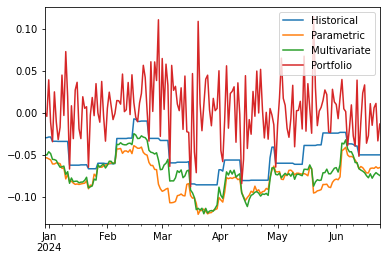

In [45]:
var_data.plot()

<AxesSubplot:>

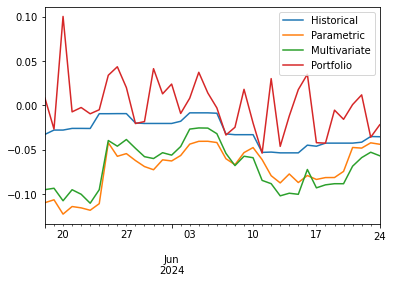

In [46]:
current_var_data.plot()

In [47]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.061798,0.0,0.0
Kupiec Stat,0.486756,18.260413,18.260413
P-value,0.485378,0.000019,0.000019


In [48]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.131579,0.0,0.0
Kupiec Stat,3.75001,3.89829,3.89829
P-value,0.052807,0.048335,0.048335


## Principal Component Analysis

In [49]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75866502, 0.08076617, 0.06293683, 0.05012577, 0.0475062 ])

In [50]:
eigval,eigvec,portfolio_components=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.57545388, 0.18316131, 0.10953638, 0.09326661, 0.03858181])